In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/MyDrive/6.862_MachineLearningProject/BuildingEnergyConsumption/Code

/content/drive/MyDrive/6.862_MachineLearningProject/BuildingEnergyConsumption/Code


In [3]:
# Imports:
import numpy as np
import pandas as pd
import os
from os.path import join
import glob
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.pyplot import figure
import datetime

from load_and_process_data import process_data
from load_electricity_school_data import load_electricity_education
from feature_encoding_and_data_splitting import split_data, prepare_data_simple_encoding, prepare_data_polynomial_encoding
from linear_regression_functions import learn_parameters, plot_loss_history, plot_test_and_prediction, plot_linear_regression_weights

import autosklearn
from autosklearn import *
import autosklearn.regression
#import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor



import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

/usr/local/lib/python3.7/dist-packages/pyparsing.py:3190: FutureWarning: Possible set intersection at position 3
  self.re = re.compile(self.reString)


In [ ]:
def calculate_rmse_metric(y_pred,y_test):
  return np.sqrt(np.mean((y_pred - y_test)**2))

###General information:
We refer the reader of this notebook to first read the README file on Github and milestone report that can be found in the Writeup folder.
####Code description:
This is the **main code** for Regression prediction for this project. Codes that I used to develop this one are  Development_FeatureEncodingLinReg_firsttry.ipynb and Development_LinearRegression.ipynb. Based on these two codes, I wrote helper functions that I am importing for this code.
####Data used:
For this project, as described in milestone report, I decided, as a first step, to make electricity consumption predictions only for  buildings whose primary use type is Educational that have very small number of missing consumption data. To extend this to different types of buildings (e.g. offices) I would do one-hot encoding for the primary_use feature. 

####Aim of this code:
Using this code I would like to understand how different types of feature encodings affect the prediction of different regression model including linear regression, decision tree regression, random forest regression and autosklearn regression. Two types of encodings used are named simple encoding and polynomial encoding. At the end of this code, I will provide discussion on results based on these two different approaches.

### 1. Load data:

I use the process_data function to load all the data from datafolder. This function also handles missing feature data. The breakdown of missing information for different features is given below: 
<br>

**Building features**:
* 53.4% of the year built
* 75.5% of the floor count

**Weather features**
* 9.5% of the cloud coverage
* 0.1% of the dew temperature
* 36.0% of the precipitation depth
* 7.6% of the sea level pressure
* 4.5% of the wind speed
* 0.2% of the wind direction.

In order to have the largest amount of data on which our model can learn, I filled all the missing information for the above mentioned featues. 
* For the **weather data** features, I filled the missing data by taking the average of the closest non missing values of that feature. My reasoning was that weather data changes slowly enough that missing feature values should have values close to the neighbouring non-missing values.
* For the **building data** I filled the missing data for the feature with the mean of that feature for that building's primary use group. My reasoning was that all the buidlings with the same primary use will have similar number of floors and that they could all be built at the similar time.

After this processing I use load_electricity_education function to load only electricity consumption data on educational buildings that have small number of missing consumption data. After this function I end up working with electricity consumption data over one year period for 118 buildings.

In [ ]:
# In colab import files like:
datafolder = '../Data/ashrae-energy-prediction/'
pd_all = process_data(datafolder)
# Load all Education buildings Electricity consumption data that has good 
# electricity meter reading values:
pd_educational = load_electricity_education(pd_all)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


#### Plot the imported data:
Here I am plotting energy consumption data averaged over 118 buildings over 1 year period timescale.

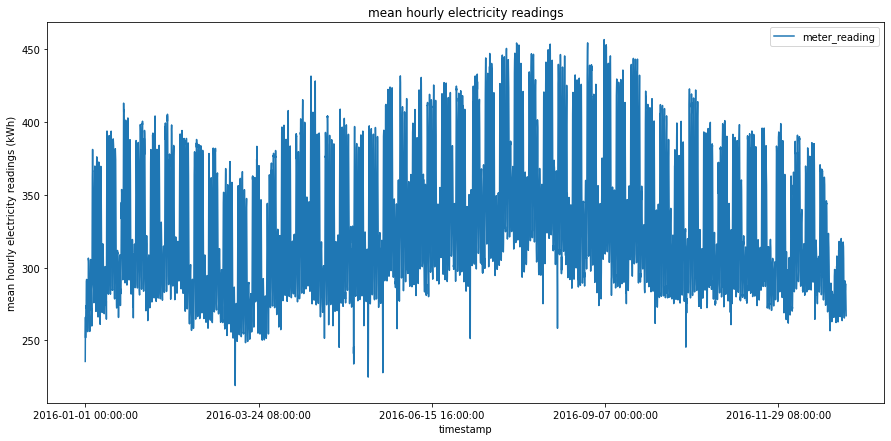

In [ ]:
pd_educational.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]).plot(figsize =(15,7), ylabel = "mean hourly electricity readings (kWh)", title = "mean hourly electricity readings")
plt.show()

#### Display pd_educational dataframe:

In [ ]:
pd_educational

,square_feet,year_built,floor_count,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,meter_reading
1707550,72102,1970.0,5.0,2016-01-01 00:00:00,15.6,6.0,-5.6,0.0,1015.30,270.0,3.6,77.610
1707553,72102,1970.0,5.0,2016-01-01 01:00:00,13.9,4.0,-5.6,0.0,1015.60,270.0,4.1,75.830
1707556,72102,1970.0,5.0,2016-01-01 02:00:00,13.3,2.0,-5.6,0.0,1016.00,270.0,3.1,80.570
1707559,72102,1970.0,5.0,2016-01-01 03:00:00,12.2,0.0,-6.1,0.0,1016.60,280.0,3.1,81.530
1707562,72102,1970.0,5.0,2016-01-01 04:00:00,11.7,2.0,-6.7,0.0,1017.00,270.0,3.1,83.550
...,...,...,...,...,...,...,...,...,...,...,...,...
20068262,30143,1951.0,5.0,2016-12-31 19:00:00,3.0,1.0,-8.0,-1.0,1007.55,180.0,5.7,245.675
20068263,30143,1951.0,5.0,2016-12-31 20:00:00,2.8,2.0,-8.9,-1.0,1007.40,180.0,7.7,250.125
20068264,30143,1951.0,5.0,2016-12-31 21:00:00,2.8,2.0,-7.2,-1.0,1007.50,180.0,5.1,247.875
20068265,30143,1951.0,5.0,2016-12-31 22:00:00,2.2,2.0,-6.7,-1.0,1008.00,170.0,4.6,247.575


### 2. Linear regression on simply encoded data:

In an attempt to fit the data plotted above I first tried to do simple feature encoding and feed those features to our linear regression model for learning.

For this simple encoding I replaced the timestamp feature with hour, weekday and month feature. After this I normalized all the input features, including these and this was the input for my learning algorithm. I also normalized the target features in this input to have a better idea what the loss value means.


#### 2.1. Prepare data for linear regression fitting by doing feature encoding and splitting it into train and test:

Function prepare_data_simple_encoding does all the feature encoding as described above. This function also splits the data into train and test data. I wanted to have a better visual picture of what the linear regression model does for different encodings, so instead of doing random split of the data for training and testing, I decided to do more structured splitting. In this function I dedicate data from the month of June to test data, and the rest of the data I dedicate to training (+validation). I originally split the data into first 11 months for training and last month for testing, however, due to holidays, December is not typical consumption month and I ended up choosing June instead for test. For the next step in this project, I can find a better way to split the data into train and test.

In [ ]:
train_data_s, test_data_s, timestamp_train_s, timestamp_test_s = prepare_data_simple_encoding(pd_educational) 

/content/drive/MyDrive/6.862_MachineLearningProject/BuildingEnergyConsumption/Code/feature_encoding_and_data_splitting.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd_test = pd_test[pd.to_datetime(pd_educational["timestamp"]) < datetime.datetime(2016, 7, 1)]


#### 2.2. Do linear regression fit:

Function learn_parameters will take the train and test data, learning rate and batch size and it will perform linear regression model fit to the train data. This function will also take 20% of the training data and it will use it for validation. I use Mean Squared error as a loss function, and Adam optimization as an optimizer. The learning rate and batch size provided below gave me the best fitting to the test data.

In [ ]:
linear_regression_model_s, history_s = learn_parameters(train_data_s, test_data_s, 0.00003, 256 )

Epoch 1/15
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: smac attempted to use a functionality that requires module emcee, but it couldn't be loaded. Please install emcee and retry.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: smac attempted to use a functionality that requires module emcee, but it couldn't be loaded. Please install emcee and retry.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: smac attempted to use a functionality that requires module emcee, but it couldn't be loaded. Please install emcee and retry.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2796/2823 [============================>.] - ETA: 0s - loss: 2.5664WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f259465a5f0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: smac attempted to use a functionality that requires module emcee, but it couldn't be loaded. Please install emcee and retry.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: smac attempted to use a functionality that requires module emcee, but it couldn't be loaded. Please install emcee and retry.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: smac attempted to use a functionality that requires module emcee, but it couldn't be loaded. Please install emcee and retry.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2823/2823 [==============================] - 7s 2ms/step - loss: 2.5650 - val_loss: 2.7026
Epoch 2/15
2823/2823 [==============================] - 5s 2ms/step - loss: 2.0096 - val_loss: 2.3058
Epoch 3/15
2823/2823 [==============================] - 5s 2ms/step - loss: 1.5896 - val_loss: 1.9572
Epoch 4/15
2823/2823 [==============================] - 5s 2ms/step - loss: 1.2915 - val_loss: 1.6561
Epoch 5/15
2823/2823 [==============================] - 5s 2ms/step - loss: 1.0820 - val_loss: 1.4140
Epoch 6/15
2823/2823 [==============================] - 5s 2ms/step - loss: 0.9342 - val_loss: 1.2278
Epoch 7/15
28

#### 2.3. Plot learning history of linear regression:

Here I am plotting learning history of linear regression model for the case of simple encoding.

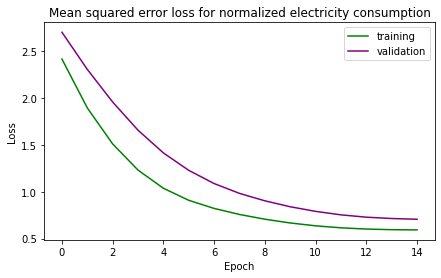

In [ ]:
plot_loss_history(history_s)

#### 2.4. Plot test data and our prediction with this model for visual comparioson:

In this part I am plotting test data in orange and our prediction in gray for the linear regression model with simple feature encoding. 

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: smac attempted to use a functionality that requires module emcee, but it couldn't be loaded. Please install emcee and retry.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: smac attempted to use a functionality that requires module emcee, but it couldn't be loaded. Please install emcee and retry.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: smac attempted to use a functionality that requires module emcee, but it couldn't be loaded. Please install emcee and retry.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

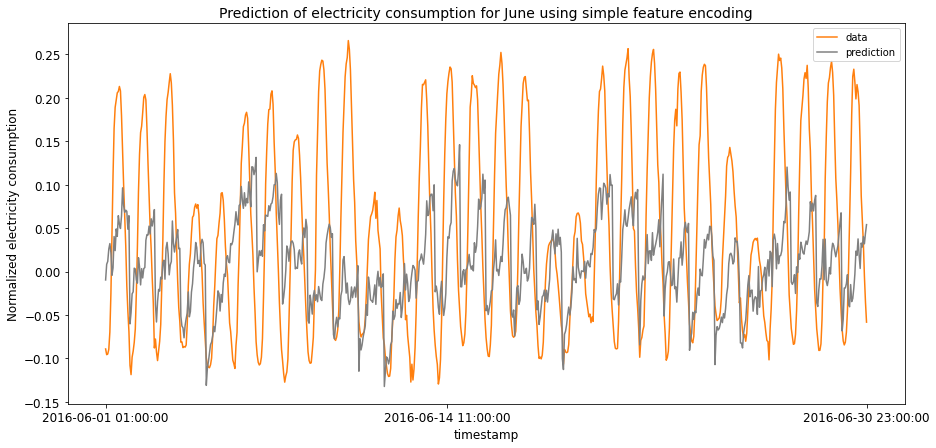

In [ ]:
plot_test_and_prediction(test_data_s, timestamp_test_s, linear_regression_model_s, 'simple')

#### 2.5. Plot weights that our model gave to different encoded features:

I was also interested to know which features contribute the most to the model, and the plot below shows this. As expected square_feet has huge contribution, however, a bit undexpected to me, the rest of the features (expect from floor_count and percipitation depth) seem to have very similar weight after learning. I was expecting time features and air_temperature to have more significant contribution than they actually have. 

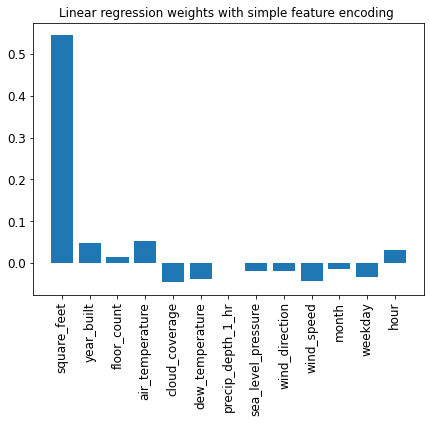

In [ ]:
plot_linear_regression_weights(train_data_s,linear_regression_model_s, 'simple')

#### 2.6. Display the metric:

Here I am displaying the root mean squared error metric for linear regression with simple encoding:

In [ ]:
test_features_s = test_data_s[0]
test_labels_s = test_data_s[1]
test_features_new = test_features_s.copy()
y_pred_s = linear_regression_model_s.predict(test_features_s)
y_norm_s= pd.DataFrame(y_pred_s, columns = ['prediction'])
y_norm_s['timestamp'] = np.array(timestamp_test_s)
test_features_new['meter_reading']  = test_labels_s
test_features_new['timestamp']  = np.array(timestamp_test_s) 

y_test_all = test_features_new.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]).meter_reading.values
y_hat_all = y_norm_s.groupby(by = "timestamp").mean().filter(["timestamp", "prediction"]).prediction.values
calculate_rmse_metric(y_test_all,y_hat_all)

0.11081880732886504

### 3. Linear regression on polynomially encoded data:

I did polynomial encoding on timestamp and wind features data. I also made year built feature cathegorical.

**Timestamp feature** <br>
A more involved encoding, that I called polynomial encoding, was inspired by Moon et al paper that I cite in the milestone report. In this paper they transformed calendar time into a 2d continuous format. This encoding looks something like this: 

\begin{equation}
 \text{day_sin} = \sin(\frac{2\pi * \text{timestamp} }{24h})  
\end{equation}
\begin{equation}
 \text{day_cos} = \cos(\frac{2\pi * \text{timestamp} }{24h}) 
\end{equation}

Given that energy consumption has clear daily variations, if we encode day as a numeric feature, then even though 0000hrs follows right after 2359hrs, they will numerically look like they are far apart. This encoding solves this problem by substituting day feature with day_sin  and day_cos feature, with frequency that corresponds to a 24h. I used this type of encoding for day, week and year feature and with frequency of 24h, 7days and 365days respectively. <br>
I also added additional feature called is\_weekday to handle lower amplitudes of energy consumption over weekend relative to weekdays.

**Wind fearture** <br>
Wind_direction feature in units of degrees has similar issue as described above, where 0 and 359 degrees are numerically far away but in reality they are close. Thus I substituted wind_speed and wind_direction features by combining them together into wind\_x and wind\_y features. <br>

**Year built feature** <br>
For year\_built feature instead of making it numeric, I grouped it into categories of 40 year period given that histogram of year_built feature showed 3 peaks across 40 year period. <br>

After these encodings, I normalized all the input features before sending it to the learning algorithm. This encoding didn't really change our prediction much in the end.

#### 3.1. Prepare data for linear regression fitting by doing feature encoding and splitting it into train and test:

Function prepare_data_polynomial_encoding applies the polynomial encoding described above, and it does the same type of training/test splitting as described above for the prepare_data_simple_encoding function.

In [ ]:
train_data_p, test_data_p, timestamp_train_p, timestamp_test_p = prepare_data_polynomial_encoding(pd_educational) 

/content/drive/MyDrive/6.862_MachineLearningProject/BuildingEnergyConsumption/Code/feature_encoding_and_data_splitting.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd_test = pd_test[pd.to_datetime(pd_educational["timestamp"]) < datetime.datetime(2016, 7, 1)]


#### 3.2. Do linear regression fit:

Function learn_parameters will take the train and test data, learning rate and batch size and it will perform linear regression model fit to the train data. This function will also take 20% of the training data and it will use it for validation. I use Mean Squared error as a loss function, and Adam optimization as an optimizer. The learning rate and batch size provided below gave me the best fitting to the test data.

In [ ]:
linear_regression_model_p, history_p = learn_parameters(train_data_p, test_data_p, 0.00003, 256 )

Epoch 1/15
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: smac attempted to use a functionality that requires module emcee, but it couldn't be loaded. Please install emcee and retry.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: smac attempted to use a functionality that requires module emcee, but it couldn't be loaded. Please install emcee and retry.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: smac attempted to use a functionality that requires module emcee, but it couldn't be loaded. Please install emcee and retry.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2816/2823 [============================>.] - ETA: 0s - loss: 2.1868WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f259454b200> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: smac attempted to use a functionality that requires module emcee, but it couldn't be loaded. Please install emcee and retry.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: smac attempted to use a functionality that requires module emcee, but it couldn't be loaded. Please install emcee and retry.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: smac attempted to use a functionality that requires module emcee, but it couldn't be loaded. Please install emcee and retry.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2823/2823 [==============================] - 6s 2ms/step - loss: 2.1863 - val_loss: 2.5555
Epoch 2/15
2823/2823 [==============================] - 5s 2ms/step - loss: 1.5136 - val_loss: 1.8819
Epoch 3/15
2823/2823 [==============================] - 5s 2ms/step - loss: 1.0914 - val_loss: 1.4199
Epoch 4/15
2823/2823 [==============================] - 5s 2ms/step - loss: 0.8506 - val_loss: 1.1270
Epoch 5/15
2823/2823 [==============================] - 5s 2ms/step - loss: 0.7163 - val_loss: 0.9456
Epoch 6/15
2823/2823 [==============================] - 5s 2ms/step - loss: 0.6405 - val_loss: 0.8328
Epoch 7/15
28

#### 3.3. Plot learning history of linear regression:

Here I am plotting learning history of linear regression model for the case of polynomial encoding.

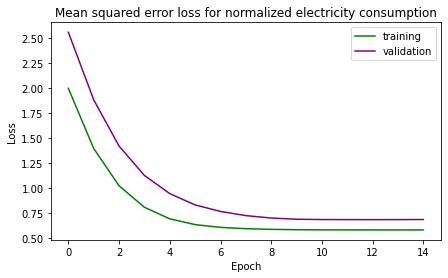

In [ ]:
plot_loss_history(history_p)

#### 3.4. Plot test data and our prediction with this model for visual comparioson:

In this part I am plotting test data in orange and our prediction in gray for the linear regression model with polynomial feature encoding. <br>

As expected, the more involved encoding that takes into account cyclical nature of electricity consumption gave better prediction of the test data compared to encoding that assumed the target data depends only linearly on the input features. The polynomial encoding was able to capture hourly variations, as well as the fact that over weekend, electricity consumption was lower compared to weekday consumption for educational buildings. 

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: smac attempted to use a functionality that requires module emcee, but it couldn't be loaded. Please install emcee and retry.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: smac attempted to use a functionality that requires module emcee, but it couldn't be loaded. Please install emcee and retry.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: smac attempted to use a functionality that requires module emcee, but it couldn't be loaded. Please install emcee and retry.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

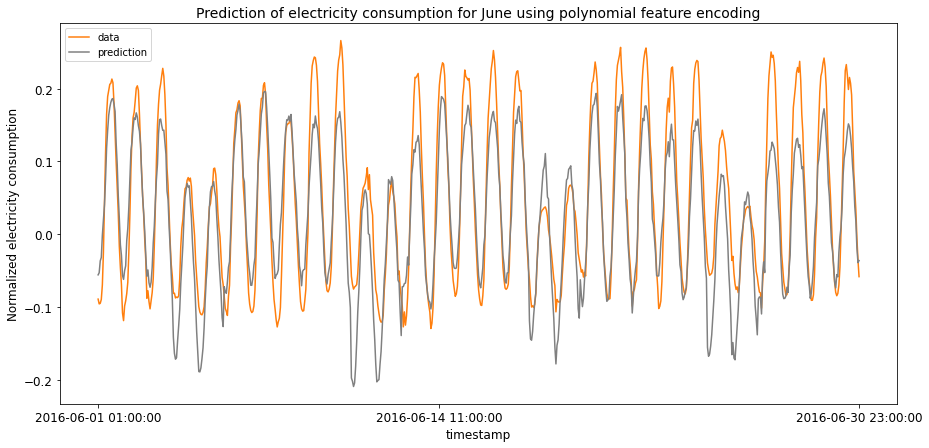

In [ ]:
plot_test_and_prediction(test_data_p, timestamp_test_p, linear_regression_model_p, 'polynomial')

#### 3.5. Plot weights that our model gave to different encoded features:

Just like in previous section I am here plotting weights of linear regression model. Square_feet has huge contribution again, but the rest of the features don't seem to be as dominant as the square_feet which was surprising to me. 

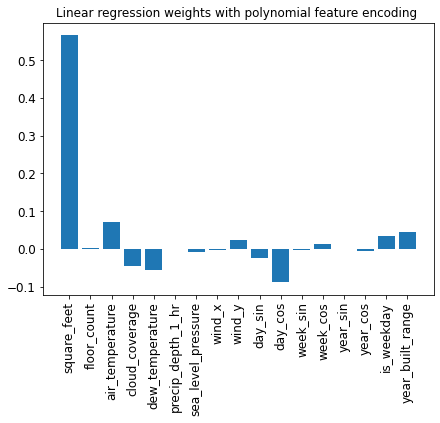

In [ ]:
plot_linear_regression_weights(train_data_p,linear_regression_model_p, 'polynomial')

#### 3.6. Display the metric:

Here I am displaying the root mean squared error metric for linear regression with polynomial encoding:

In [ ]:
test_features_p = test_data_p[0]
test_labels_p = test_data_p[1]
test_features_new = test_features_p.copy()
y_pred_p = linear_regression_model_p.predict(test_features_p)
y_norm_p= pd.DataFrame(y_pred_p, columns = ['prediction'])
y_norm_p['timestamp'] = np.array(timestamp_test_p)
test_features_new['meter_reading']  = test_labels_p
test_features_new['timestamp']  = np.array(timestamp_test_p) 

y_test_all = test_features_new.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]).meter_reading.values
y_hat_all = y_norm_p.groupby(by = "timestamp").mean().filter(["timestamp", "prediction"]).prediction.values
calculate_rmse_metric(y_test_all,y_hat_all)

0.05138021156960679

### 4. Decision tree regression:

In this section I would like to check predictions I can get with decision tree regression model. I will compare results I get with polynomial encoding, simple encoding and no encoding.

#### 4.1. Decision tree regression with polynomial encoding:

In [ ]:
train_data, test_data, timestamp_train, timestamp_test = prepare_data_polynomial_encoding(pd_educational)
(X_train,y_train) = train_data
(X_test,y_test) = test_data

/content/drive/MyDrive/6.862_MachineLearningProject/BuildingEnergyConsumption/Code/feature_encoding_and_data_splitting.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd_test = pd_test[pd.to_datetime(pd_educational["timestamp"]) < datetime.datetime(2016, 7, 1)]


In [ ]:
clf = tree.DecisionTreeRegressor()#max_depth=400)
clf = clf.fit(X_train, y_train)
y_hat = clf.predict(X_test)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

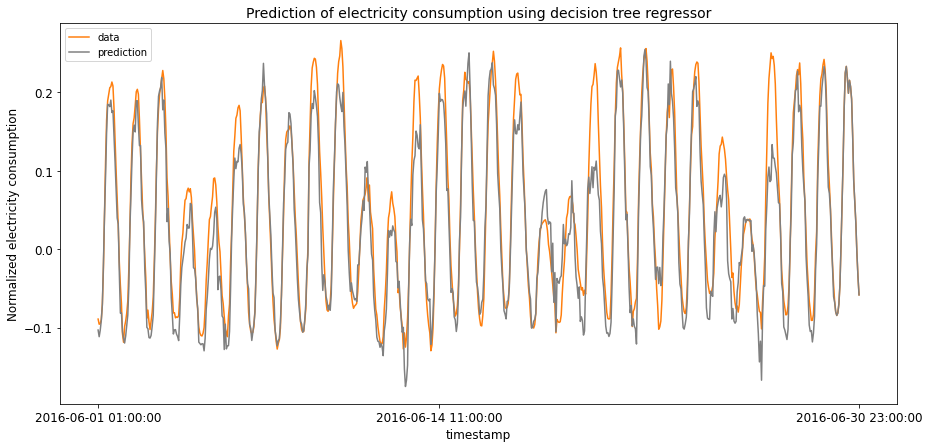

In [ ]:
pred = {'prediction': y_hat, 'timestamp': timestamp_test}
y_norm_p = pd.DataFrame(data=pred)
test_val = {'meter_reading':y_test, 'timestamp': timestamp_test}
test_features_new_p= pd.DataFrame(data=test_val)

figure(figsize =(15,7))
plt.plot(test_features_new_p.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]), color = 'C1', label = 'data')
plt.plot(y_norm_p.groupby(by = "timestamp").mean().filter(["timestamp", "prediction"]), color = 'gray', label = 'prediction')
plt.xlabel('timestamp', fontsize = 12)
plt.ylabel('Normalized electricity consumption', fontsize = 12)
plt.title('Prediction of electricity consumption using decision tree regressor', fontsize = 14)
len_ts = len(timestamp_test.values)
plt.xticks([timestamp_test.values[0],timestamp_test.values[int(len_ts/2)],timestamp_test.values[-1]], fontsize = '12')
plt.yticks(fontsize = 12)
plt.legend()
plt.show()

##### Display metric:

In [ ]:
y_test_all = test_features_new_p.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]).meter_reading.values
y_hat_all = y_norm_p.groupby(by = "timestamp").mean().filter(["timestamp", "prediction"]).prediction.values

calculate_rmse_metric(y_test_all,y_hat_all)

0.034840712945349094

#### 4.2. Decision tree regression with simple encoding:

In [ ]:
train_data, test_data, timestamp_train, timestamp_test = prepare_data_simple_encoding(pd_educational)
(X_train,y_train) = train_data
(X_test,y_test) = test_data

/content/drive/MyDrive/6.862_MachineLearningProject/BuildingEnergyConsumption/Code/feature_encoding_and_data_splitting.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd_test = pd_test[pd.to_datetime(pd_educational["timestamp"]) < datetime.datetime(2016, 7, 1)]


In [ ]:
clf = tree.DecisionTreeRegressor()#max_depth=400)
clf = clf.fit(X_train, y_train)
y_hat = clf.predict(X_test)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

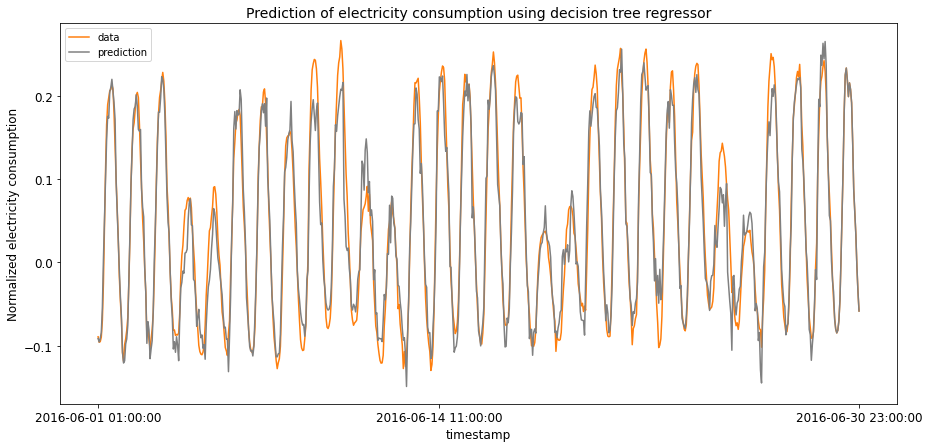

In [ ]:
pred = {'prediction': y_hat, 'timestamp': timestamp_test}
y_norm_p = pd.DataFrame(data=pred)
test_val = {'meter_reading':y_test, 'timestamp': timestamp_test}
test_features_new_p= pd.DataFrame(data=test_val)

figure(figsize =(15,7))
plt.plot(test_features_new_p.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]), color = 'C1', label = 'data')
plt.plot(y_norm_p.groupby(by = "timestamp").mean().filter(["timestamp", "prediction"]), color = 'gray', label = 'prediction')
plt.xlabel('timestamp', fontsize = 12)
plt.ylabel('Normalized electricity consumption', fontsize = 12)
plt.title('Prediction of electricity consumption using decision tree regressor', fontsize = 14)
len_ts = len(timestamp_test.values)
plt.xticks([timestamp_test.values[0],timestamp_test.values[int(len_ts/2)],timestamp_test.values[-1]], fontsize = '12')
plt.yticks(fontsize = 12)
plt.legend()
plt.show()

##### Display metric:

In [ ]:
y_test_all = test_features_new_p.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]).meter_reading.values
y_hat_all = y_norm_p.groupby(by = "timestamp").mean().filter(["timestamp", "prediction"]).prediction.values

calculate_rmse_metric(y_test_all,y_hat_all)

0.026117041716603662

#### 4.3. Decision tree regression with no encoding:

In [ ]:
pd_train = pd.concat([pd_educational.loc[pd.to_datetime(pd_educational["timestamp"]) < datetime.datetime(2016, 6, 1)] , pd_educational.loc[pd.to_datetime(pd_educational["timestamp"]) > datetime.datetime(2016, 6, 30)]])
pd_test = pd_educational.loc[pd.to_datetime(pd_educational["timestamp"]) > datetime.datetime(2016, 6, 1)] 
pd_test = pd_test[pd.to_datetime(pd_educational["timestamp"]) < datetime.datetime(2016, 7, 1)]

y_train = pd_train.pop('meter_reading')
y_test = pd_test.pop('meter_reading')
X_train = pd_train
X_test = pd_test
timestamp_train = X_train.pop('timestamp')
timestamp_test = X_test.pop('timestamp')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
clf = tree.DecisionTreeRegressor()#max_depth=400)
clf = clf.fit(X_train, y_train)
y_hat = clf.predict(X_test)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

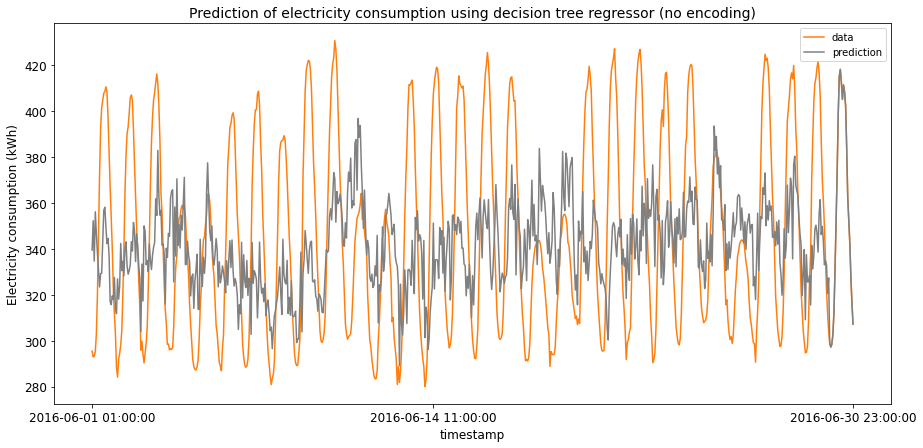

In [ ]:
pred = {'prediction': y_hat, 'timestamp': timestamp_test}
y_norm_p = pd.DataFrame(data=pred)
test_val = {'meter_reading':y_test, 'timestamp': timestamp_test}
test_features_new_p= pd.DataFrame(data=test_val)

figure(figsize =(15,7))
plt.plot(test_features_new_p.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]), color = 'C1', label = 'data')
plt.plot(y_norm_p.groupby(by = "timestamp").mean().filter(["timestamp", "prediction"]), color = 'gray', label = 'prediction')
plt.xlabel('timestamp', fontsize = 12)
plt.ylabel('Electricity consumption (kWh)', fontsize = 12)
plt.title('Prediction of electricity consumption using decision tree regressor (no encoding)', fontsize = 14)
len_ts = len(timestamp_test.values)
plt.xticks([timestamp_test.values[0],timestamp_test.values[int(len_ts/2)],timestamp_test.values[-1]], fontsize = '12')
plt.yticks(fontsize = 12)
plt.legend()
plt.show()

##### Display metric:

In [ ]:
std = np.std(y_test.values)
y_test_all = test_features_new_p.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]).meter_reading.values
y_hat_all = y_norm_p.groupby(by = "timestamp").mean().filter(["timestamp", "prediction"]).prediction.values
calculate_rmse_metric(y_test_all,y_hat_all)/std

0.09703208917858276

### 5. Random forest regression:

In this section I would like to check predictions I can get with random forest regression model. I will compare results I get with polynomial encoding, simple encoding and no encoding.

#### 5.1. Random forest regression with polynomial encoding:

In [ ]:
train_data, test_data, timestamp_train, timestamp_test = prepare_data_polynomial_encoding(pd_educational)
(X_train,y_train) = train_data
(X_test,y_test) = test_data

/content/drive/MyDrive/6.862_MachineLearningProject/BuildingEnergyConsumption/Code/feature_encoding_and_data_splitting.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd_test = pd_test[pd.to_datetime(pd_educational["timestamp"]) < datetime.datetime(2016, 7, 1)]


In [ ]:
clf = RandomForestRegressor(n_estimators=30)#max_depth=400)
clf = clf.fit(X_train, y_train)
y_hat = clf.predict(X_test)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

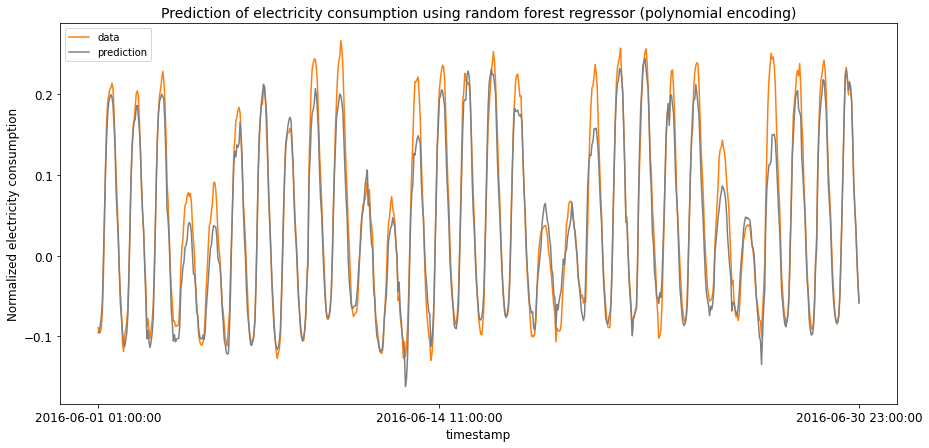

In [ ]:
pred = {'prediction': y_hat, 'timestamp': timestamp_test}
y_norm_p = pd.DataFrame(data=pred)
test_val = {'meter_reading':y_test, 'timestamp': timestamp_test}
test_features_new_p= pd.DataFrame(data=test_val)

figure(figsize =(15,7))
plt.plot(test_features_new_p.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]), color = 'C1', label = 'data')
plt.plot(y_norm_p.groupby(by = "timestamp").mean().filter(["timestamp", "prediction"]), color = 'gray', label = 'prediction')
plt.xlabel('timestamp', fontsize = 12)
plt.ylabel('Normalized electricity consumption', fontsize = 12)
plt.title('Prediction of electricity consumption using random forest regressor (polynomial encoding)', fontsize = 14)
len_ts = len(timestamp_test.values)
plt.xticks([timestamp_test.values[0],timestamp_test.values[int(len_ts/2)],timestamp_test.values[-1]], fontsize = '12')
plt.yticks(fontsize = 12)
plt.legend()
plt.show()

##### Display metric:

In [ ]:
y_test_all = test_features_new_p.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]).meter_reading.values
y_hat_all = y_norm_p.groupby(by = "timestamp").mean().filter(["timestamp", "prediction"]).prediction.values
calculate_rmse_metric(y_test_all,y_hat_all)

0.02596735898467121

#### 5.2. Random forest regression with simple encoding:

In [ ]:
train_data, test_data, timestamp_train, timestamp_test = prepare_data_simple_encoding(pd_educational)
(X_train,y_train) = train_data
(X_test,y_test) = test_data

/content/drive/MyDrive/6.862_MachineLearningProject/BuildingEnergyConsumption/Code/feature_encoding_and_data_splitting.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd_test = pd_test[pd.to_datetime(pd_educational["timestamp"]) < datetime.datetime(2016, 7, 1)]


In [ ]:
clf = RandomForestRegressor(n_estimators=30)#max_depth=400)
clf = clf.fit(X_train, y_train)
y_hat = clf.predict(X_test)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

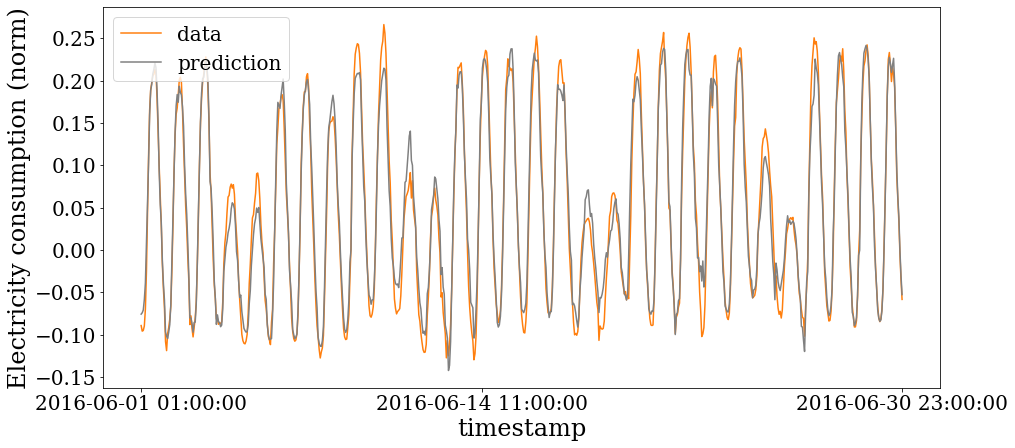

In [ ]:
pred = {'prediction': y_hat, 'timestamp': timestamp_test}
y_norm_p = pd.DataFrame(data=pred)
test_val = {'meter_reading':y_test, 'timestamp': timestamp_test}
test_features_new_p= pd.DataFrame(data=test_val)

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

figure(figsize =(15,7))
plt.plot(test_features_new_p.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]), color = 'C1', label = 'data')
plt.plot(y_norm_p.groupby(by = "timestamp").mean().filter(["timestamp", "prediction"]), color = 'gray', label = 'prediction')
plt.xlabel('timestamp', fontsize = 24)
plt.ylabel('Electricity consumption (norm)', fontsize = 24)
#plt.title('Prediction of electricity consumption using random forest regressor and simple encoding', fontsize = 14)
len_ts = len(timestamp_test.values)
plt.xticks([timestamp_test.values[0],timestamp_test.values[int(len_ts/2)],timestamp_test.values[-1]], fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend( fontsize = 20, loc = 'upper left')
plt.savefig('RFR_simple.pdf', transparency = True,bbox_inches='tight')
plt.show()

##### Display metric:

In [ ]:
y_test_all = test_features_new_p.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]).meter_reading.values
y_hat_all = y_norm_p.groupby(by = "timestamp").mean().filter(["timestamp", "prediction"]).prediction.values
calculate_rmse_metric(y_test_all,y_hat_all)

0.02037689680993226

#### 5.3. Random forest regression with no encoding:

In [ ]:
pd_train = pd.concat([pd_educational.loc[pd.to_datetime(pd_educational["timestamp"]) < datetime.datetime(2016, 6, 1)] , pd_educational.loc[pd.to_datetime(pd_educational["timestamp"]) > datetime.datetime(2016, 6, 30)]])
pd_test = pd_educational.loc[pd.to_datetime(pd_educational["timestamp"]) > datetime.datetime(2016, 6, 1)] 
pd_test = pd_test[pd.to_datetime(pd_educational["timestamp"]) < datetime.datetime(2016, 7, 1)]

y_train = pd_train.pop('meter_reading')
y_test = pd_test.pop('meter_reading')
X_train = pd_train
X_test = pd_test
timestamp_train = X_train.pop('timestamp')
timestamp_test = X_test.pop('timestamp')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
clf = RandomForestRegressor(n_estimators=30)#max_depth=400)
clf = clf.fit(X_train, y_train)
y_hat = clf.predict(X_test)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

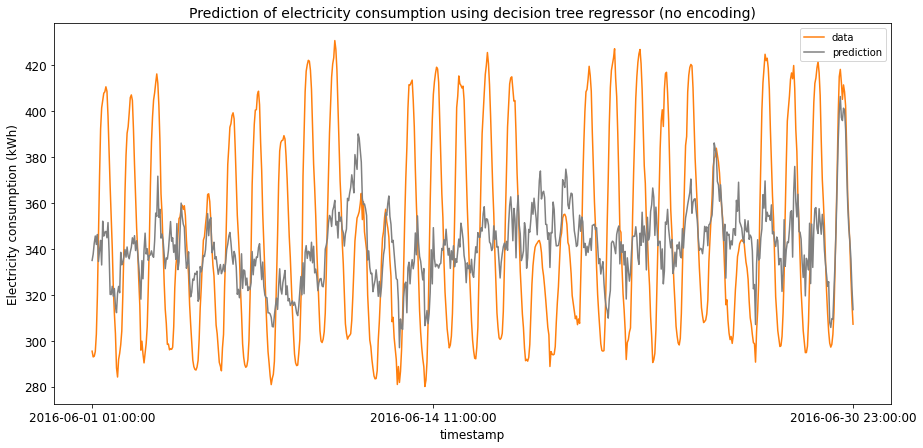

In [ ]:
pred = {'prediction': y_hat, 'timestamp': timestamp_test}
y_norm_p = pd.DataFrame(data=pred)
test_val = {'meter_reading':y_test, 'timestamp': timestamp_test}
test_features_new_p= pd.DataFrame(data=test_val)

figure(figsize =(15,7))
plt.plot(test_features_new_p.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]), color = 'C1', label = 'data')
plt.plot(y_norm_p.groupby(by = "timestamp").mean().filter(["timestamp", "prediction"]), color = 'gray', label = 'prediction')
plt.xlabel('timestamp', fontsize = 12)
plt.ylabel('Electricity consumption (kWh)', fontsize = 12)
plt.title('Prediction of electricity consumption using decision tree regressor (no encoding)', fontsize = 14)
len_ts = len(timestamp_test.values)
plt.xticks([timestamp_test.values[0],timestamp_test.values[int(len_ts/2)],timestamp_test.values[-1]], fontsize = '12')
plt.yticks(fontsize = 12)
plt.legend()
plt.show()

##### Display metric:

In [ ]:
std = np.std(y_test.values)
y_test_all = test_features_new_p.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]).meter_reading.values
y_hat_all = y_norm_p.groupby(by = "timestamp").mean().filter(["timestamp", "prediction"]).prediction.values
calculate_rmse_metric(y_test_all,y_hat_all)/std

0.09502560714161949

### 6. Autosklearn regression:

In this section I would like to check predictions I can get with autosklearn regression model. Ideally with this automated model, that automates both the feature encoding and the learning algorithm search, one should be able to make good predictions by feeding this model with data that was not processed by feature encoding. I will however also compare what we get with autosklearn when we feed the data that was processed with simple feature encoding and polynomial feature encoding. 

#### 6.1. Autosklearn with no feature encoding:

Prepare our 118 building dataset to train and test dataset:

In [ ]:
pd_train = pd.concat([pd_educational.loc[pd.to_datetime(pd_educational["timestamp"]) < datetime.datetime(2016, 6, 1)] , pd_educational.loc[pd.to_datetime(pd_educational["timestamp"]) > datetime.datetime(2016, 6, 30)]])
pd_test = pd_educational.loc[pd.to_datetime(pd_educational["timestamp"]) > datetime.datetime(2016, 6, 1)] 
pd_test = pd_test[pd.to_datetime(pd_educational["timestamp"]) < datetime.datetime(2016, 7, 1)]

y_train = pd_train.pop('meter_reading')
y_test = pd_test.pop('meter_reading')
X_train = pd_train
X_test = pd_test
timestamp_train = X_train.pop('timestamp')
timestamp_test = X_test.pop('timestamp')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


##### 6.1.2. Train model using autosklearn for 2h:

In [ ]:
automl = autosklearn.regression.AutoSklearnRegressor(time_left_for_this_task=7200, n_jobs = -1)
automl.fit(X_train, y_train)
y_hat = automl.predict(X_test)

##### 6.1.3. Print the models tried:

In [ ]:
print(automl.show_models())

[(0.580000, SimpleRegressionPipeline({'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding', 'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'no_coalescense', 'data_preprocessing:numerical_transformer:imputation:strategy': 'median', 'data_preprocessing:numerical_transformer:rescaling:__choice__': 'robust_scaler', 'feature_preprocessor:__choice__': 'no_preprocessing', 'regressor:__choice__': 'gradient_boosting', 'data_preprocessing:numerical_transformer:rescaling:robust_scaler:q_max': 0.7548820011150241, 'data_preprocessing:numerical_transformer:rescaling:robust_scaler:q_min': 0.02964869664953053, 'regressor:gradient_boosting:early_stop': 'valid', 'regressor:gradient_boosting:l2_regularization': 3.1008789875481045e-10, 'regressor:gradient_boosting:learning_rate': 0.9742767231340886, 'regressor:gradient_boosting:loss': 'least_squares', 'regressor:gradient_boosting:max_bins': 255, 'regressor:gradient_boosting:max_dep

##### 6.1.4. Plot the result:

##### If this data is already saved read from file:

In [ ]:
y_norm_p = pd.read_csv('autosklearn_predictor.csv')

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

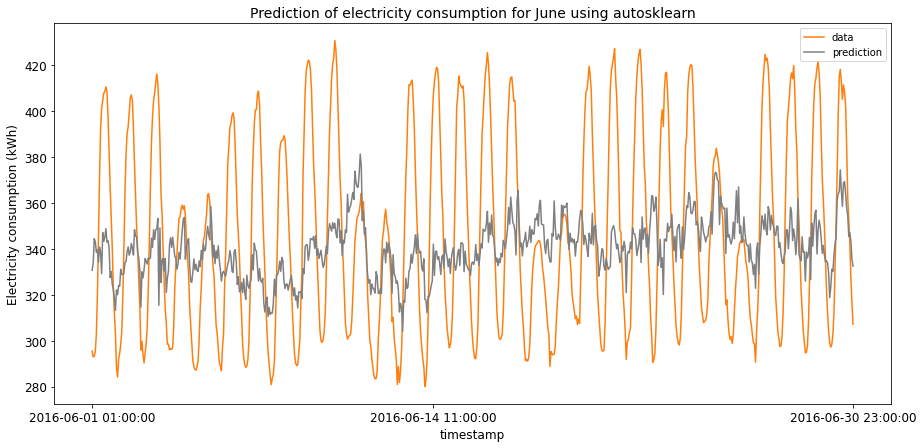

In [ ]:
#pred = {'prediction': y_hat, 'timestamp': timestamp_test}
#y_norm_p = pd.DataFrame(data=pred)
test_val = {'meter_reading':y_test, 'timestamp': timestamp_test}
test_features_new_p= pd.DataFrame(data=test_val)
#np.savetxt('autosklearn_predictor.txt',y_norm_p)

figure(figsize =(15,7))
plt.plot(test_features_new_p.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]), color = 'C1', label = 'data')
plt.plot(y_norm_p.groupby(by = "timestamp").mean().filter(["timestamp", "prediction"]), color = 'gray', label = 'prediction')
plt.xlabel('timestamp', fontsize = 12)
plt.ylabel('Electricity consumption (kWh)', fontsize = 12)
plt.title('Prediction of electricity consumption for June using autosklearn', fontsize = 14)
len_ts = len(timestamp_test.values)
plt.xticks([timestamp_test.values[0],timestamp_test.values[int(len_ts/2)],timestamp_test.values[-1]], fontsize = '12')
plt.yticks(fontsize = 12)
plt.legend()
plt.show()

##### 6.1.5. Save this prediction:

In [ ]:
y_norm_p.to_csv('autosklearn_predictor.csv',index=False)
pd_askl = pd.read_csv('autosklearn_predictor.csv')
pd_askl

,prediction,timestamp
0,105.085892,2016-06-01 01:00:00
1,105.515879,2016-06-01 02:00:00
2,105.521862,2016-06-01 03:00:00
3,104.268843,2016-06-01 04:00:00
4,104.541403,2016-06-01 05:00:00
...,...,...
81139,299.071671,2016-06-30 19:00:00
81140,299.049141,2016-06-30 20:00:00
81141,296.506916,2016-06-30 21:00:00
81142,292.932182,2016-06-30 22:00:00


##### 6.1.6. Display metric:

In [ ]:
std = np.std(y_test.values)
y_test_all = test_features_new_p.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]).meter_reading.values
y_hat_all = y_norm_p.groupby(by = "timestamp").mean().filter(["timestamp", "prediction"]).prediction.values
calculate_rmse_metric(y_test_all,y_hat_all)/std

0.09649278175716866

#### 6.2. Autosklearn with  polynomial feature encoding:
This part is not super useful because the idea of autosklearn is that non-expert would feed the data to autosklearn regression and this model would automatically find optimal feature encoding and the optimal learning algorithm. But either way I was curious to see this result.

In [ ]:
train_data, test_data, timestamp_train, timestamp_test = prepare_data_polynomial_encoding(pd_educational)
(X_train,y_train) = train_data
(X_test,y_test) = test_data

/content/drive/MyDrive/6.862_MachineLearningProject/BuildingEnergyConsumption/Code/feature_encoding_and_data_splitting.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd_test = pd_test[pd.to_datetime(pd_educational["timestamp"]) < datetime.datetime(2016, 7, 1)]


In [ ]:
automl = autosklearn.regression.AutoSklearnRegressor(time_left_for_this_task=3600, n_jobs = -1)
automl.fit(X_train, y_train)
y_hat = automl.predict(X_test)

In [ ]:
print(automl.show_models())

[(1.000000, SimpleRegressionPipeline({'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'no_encoding', 'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'no_coalescense', 'data_preprocessing:numerical_transformer:imputation:strategy': 'mean', 'data_preprocessing:numerical_transformer:rescaling:__choice__': 'robust_scaler', 'feature_preprocessor:__choice__': 'feature_agglomeration', 'regressor:__choice__': 'gradient_boosting', 'data_preprocessing:numerical_transformer:rescaling:robust_scaler:q_max': 0.7727512096172742, 'data_preprocessing:numerical_transformer:rescaling:robust_scaler:q_min': 0.22461598115758682, 'feature_preprocessor:feature_agglomeration:affinity': 'manhattan', 'feature_preprocessor:feature_agglomeration:linkage': 'complete', 'feature_preprocessor:feature_agglomeration:n_clusters': 21, 'feature_preprocessor:feature_agglomeration:pooling_func': 'max', 'regressor:gradient_boosting:early_stop': 'train', 'regressor:gr

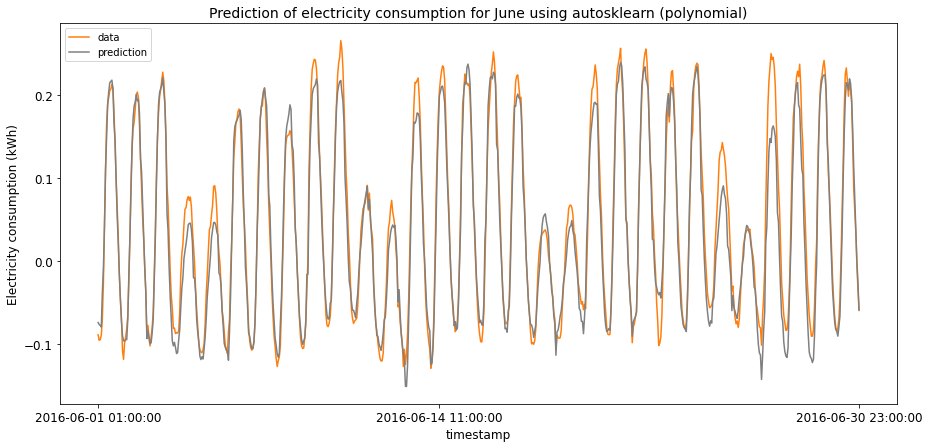

In [ ]:
pred = {'prediction': y_hat, 'timestamp': timestamp_test}
y_norm_p = pd.DataFrame(data=pred)
test_val = {'meter_reading':y_test, 'timestamp': timestamp_test}
test_features_new_p= pd.DataFrame(data=test_val)
#np.savetxt('autosklearn_predictor.txt',y_norm_p)

figure(figsize =(15,7))
plt.plot(test_features_new_p.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]), color = 'C1', label = 'data')
plt.plot(y_norm_p.groupby(by = "timestamp").mean().filter(["timestamp", "prediction"]), color = 'gray', label = 'prediction')
plt.xlabel('timestamp', fontsize = 12)
plt.ylabel('Electricity consumption (kWh)', fontsize = 12)
plt.title('Prediction of electricity consumption for June using autosklearn (polynomial)', fontsize = 14)
len_ts = len(timestamp_test.values)
plt.xticks([timestamp_test.values[0],timestamp_test.values[int(len_ts/2)],timestamp_test.values[-1]], fontsize = '12')
plt.yticks(fontsize = 12)
plt.legend()
plt.show()

##### Save this data:

In [ ]:
y_norm_p.to_csv('autosklearn_predictor_polynomial.csv',index=False)
pd_askl = pd.read_csv('autosklearn_predictor.csv')
pd_askl

,prediction,timestamp
0,105.085892,2016-06-01 01:00:00
1,105.515879,2016-06-01 02:00:00
2,105.521862,2016-06-01 03:00:00
3,104.268843,2016-06-01 04:00:00
4,104.541403,2016-06-01 05:00:00
...,...,...
81139,299.071671,2016-06-30 19:00:00
81140,299.049141,2016-06-30 20:00:00
81141,296.506916,2016-06-30 21:00:00
81142,292.932182,2016-06-30 22:00:00


In [ ]:
y_norm_p = pd.read_csv('autosklearn_predictor_polynomial.csv')

#### Calculate metric:

In [ ]:
#std = np.std(y_test.values)
y_test_all = test_features_new_p.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]).meter_reading.values
y_hat_all = y_norm_p.groupby(by = "timestamp").mean().filter(["timestamp", "prediction"]).prediction.values
calculate_rmse_metric(y_test_all,y_hat_all)#/std

0.023592265477895683

#### 6.3. Autosklearn with simple encoding:

In [ ]:
train_data, test_data, timestamp_train, timestamp_test = prepare_data_simple_encoding(pd_educational)
(X_train,y_train) = train_data
(X_test,y_test) = test_data

/content/drive/MyDrive/6.862_MachineLearningProject/BuildingEnergyConsumption/Code/feature_encoding_and_data_splitting.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd_test = pd_test[pd.to_datetime(pd_educational["timestamp"]) < datetime.datetime(2016, 7, 1)]


In [ ]:
automl = autosklearn.regression.AutoSklearnRegressor(time_left_for_this_task=3600, n_jobs = -1)
automl.fit(X_train, y_train)
y_hat = automl.predict(X_test)

In [ ]:
print(automl.show_models())

[(1.000000, SimpleRegressionPipeline({'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding', 'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer', 'data_preprocessing:numerical_transformer:imputation:strategy': 'median', 'data_preprocessing:numerical_transformer:rescaling:__choice__': 'normalize', 'feature_preprocessor:__choice__': 'fast_ica', 'regressor:__choice__': 'gradient_boosting', 'data_preprocessing:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction': 0.06781257124199082, 'feature_preprocessor:fast_ica:algorithm': 'deflation', 'feature_preprocessor:fast_ica:fun': 'exp', 'feature_preprocessor:fast_ica:whiten': 'True', 'regressor:gradient_boosting:early_stop': 'valid', 'regressor:gradient_boosting:l2_regularization': 6.845573312379887e-10, 'regressor:gradient_boosting:learning_rate': 0.08720703056354401, 'regressor:gradient_boosting:loss': 'least_squares', 'regre

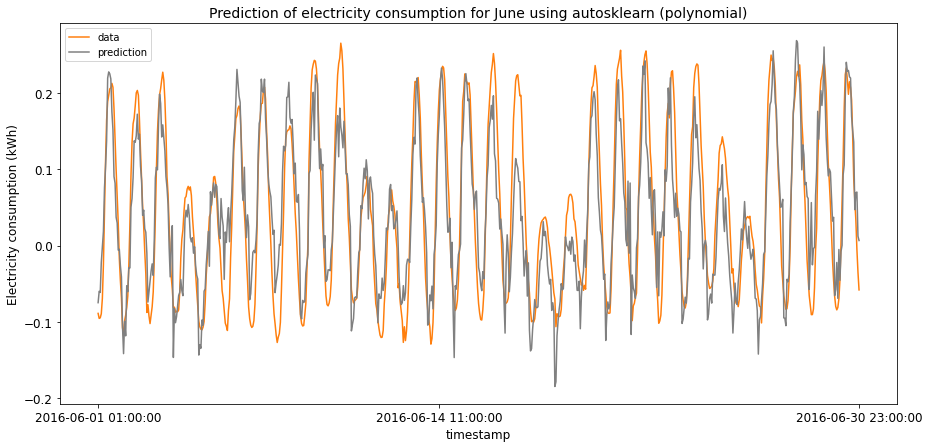

In [ ]:
pred = {'prediction': y_hat, 'timestamp': timestamp_test}
y_norm_p = pd.DataFrame(data=pred)
test_val = {'meter_reading':y_test, 'timestamp': timestamp_test}
test_features_new_p= pd.DataFrame(data=test_val)
#np.savetxt('autosklearn_predictor.txt',y_norm_p)

figure(figsize =(15,7))
plt.plot(test_features_new_p.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]), color = 'C1', label = 'data')
plt.plot(y_norm_p.groupby(by = "timestamp").mean().filter(["timestamp", "prediction"]), color = 'gray', label = 'prediction')
plt.xlabel('timestamp', fontsize = 12)
plt.ylabel('Electricity consumption (kWh)', fontsize = 12)
plt.title('Prediction of electricity consumption for June using autosklearn (polynomial)', fontsize = 14)
len_ts = len(timestamp_test.values)
plt.xticks([timestamp_test.values[0],timestamp_test.values[int(len_ts/2)],timestamp_test.values[-1]], fontsize = '12')
plt.yticks(fontsize = 12)
plt.legend()
plt.show()

##### Save the data:

In [ ]:
y_norm_p.to_csv('autosklearn_predictor_simple.csv',index=False)
pd_askl = pd.read_csv('autosklearn_predictor.csv')
pd_askl

,prediction,timestamp
0,105.085892,2016-06-01 01:00:00
1,105.515879,2016-06-01 02:00:00
2,105.521862,2016-06-01 03:00:00
3,104.268843,2016-06-01 04:00:00
4,104.541403,2016-06-01 05:00:00
...,...,...
81139,299.071671,2016-06-30 19:00:00
81140,299.049141,2016-06-30 20:00:00
81141,296.506916,2016-06-30 21:00:00
81142,292.932182,2016-06-30 22:00:00


##### Calculate the metric:

In [ ]:
#std = np.std(y_test.values)
y_test_all = test_features_new_p.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]).meter_reading.values
y_hat_all = y_norm_p.groupby(by = "timestamp").mean().filter(["timestamp", "prediction"]).prediction.values
calculate_rmse_metric(y_test_all,y_hat_all)

0.05170931594331458

#### 6.4. Let's try autosklearn with integer timestamp input but no encoding:

Turns out, as expected, that result we get here is the same as if we were to take out timestamp just like with our no feature encoding case.

In [ ]:
pd_train = pd.concat([pd_educational.loc[pd.to_datetime(pd_educational["timestamp"]) < datetime.datetime(2016, 6, 1)] , pd_educational.loc[pd.to_datetime(pd_educational["timestamp"]) > datetime.datetime(2016, 6, 30)]])
pd_test = pd_educational.loc[pd.to_datetime(pd_educational["timestamp"]) > datetime.datetime(2016, 6, 1)] 
pd_test = pd_test[pd.to_datetime(pd_educational["timestamp"]) < datetime.datetime(2016, 7, 1)]

y_train = pd_train.pop('meter_reading')
y_test = pd_test.pop('meter_reading')
X_train = pd_train
X_test = pd_test
timestamp_train = X_train.pop('timestamp')
timestamp_test = X_test.pop('timestamp')
X_train['time'] = pd.to_datetime(timestamp_train).astype(int)/10**18
X_test['time'] = pd.to_datetime(timestamp_test).astype(int)/10**18

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
automl = autosklearn.regression.AutoSklearnRegressor(time_left_for_this_task=3600, n_jobs = -1)
automl.fit(X_train, y_train)
y_hat = automl.predict(X_test)

In [ ]:
print(automl.show_models())

[(1.000000, SimpleRegressionPipeline({'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'no_encoding', 'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer', 'data_preprocessing:numerical_transformer:imputation:strategy': 'mean', 'data_preprocessing:numerical_transformer:rescaling:__choice__': 'robust_scaler', 'feature_preprocessor:__choice__': 'no_preprocessing', 'regressor:__choice__': 'k_nearest_neighbors', 'data_preprocessing:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction': 0.00397868572473159, 'data_preprocessing:numerical_transformer:rescaling:robust_scaler:q_max': 0.7840854273341944, 'data_preprocessing:numerical_transformer:rescaling:robust_scaler:q_min': 0.11376189722146844, 'regressor:k_nearest_neighbors:n_neighbors': 20, 'regressor:k_nearest_neighbors:p': 2, 'regressor:k_nearest_neighbors:weights': 'distance'},
dataset_properties={
  'task': 4,
  'sparse': False,
  'mul

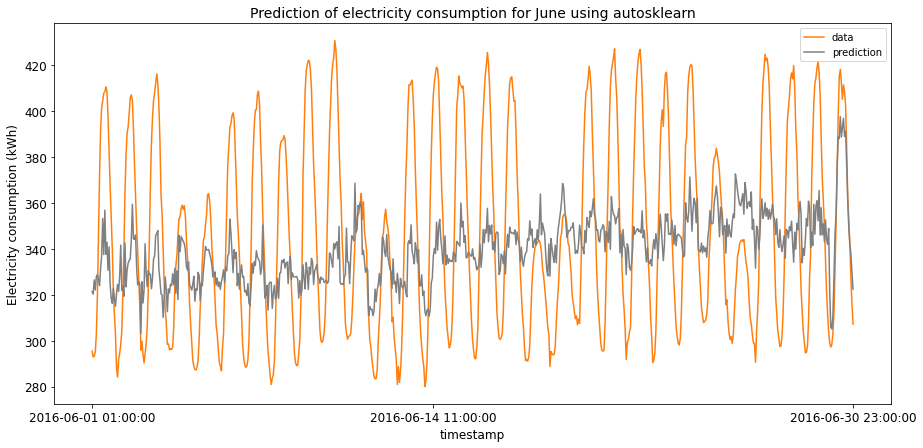

In [ ]:
pred = {'prediction': y_hat, 'timestamp': timestamp_test}
y_norm_p = pd.DataFrame(data=pred)
test_val = {'meter_reading':y_test, 'timestamp': timestamp_test}
test_features_new_p= pd.DataFrame(data=test_val)
#np.savetxt('autosklearn_predictor.txt',y_norm_p)

figure(figsize =(15,7))
plt.plot(test_features_new_p.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]), color = 'C1', label = 'data')
plt.plot(y_norm_p.groupby(by = "timestamp").mean().filter(["timestamp", "prediction"]), color = 'gray', label = 'prediction')
plt.xlabel('timestamp', fontsize = 12)
plt.ylabel('Electricity consumption (kWh)', fontsize = 12)
plt.title('Prediction of electricity consumption for June using autosklearn', fontsize = 14)
len_ts = len(timestamp_test.values)
plt.xticks([timestamp_test.values[0],timestamp_test.values[int(len_ts/2)],timestamp_test.values[-1]], fontsize = '12')
plt.yticks(fontsize = 12)
plt.legend()
plt.show()

##### Save this data:

In [ ]:
y_norm_p.to_csv('autosklearn_predictor_integerencoding.csv',index=False)
pd_askl = pd.read_csv('autosklearn_predictor.csv')
pd_askl

,prediction,timestamp
0,105.085892,2016-06-01 01:00:00
1,105.515879,2016-06-01 02:00:00
2,105.521862,2016-06-01 03:00:00
3,104.268843,2016-06-01 04:00:00
4,104.541403,2016-06-01 05:00:00
...,...,...
81139,299.071671,2016-06-30 19:00:00
81140,299.049141,2016-06-30 20:00:00
81141,296.506916,2016-06-30 21:00:00
81142,292.932182,2016-06-30 22:00:00


##### Calculate metric:

In [ ]:
std = np.std(y_test.values)
y_test_all = test_features_new_p.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]).meter_reading.values
y_hat_all = y_norm_p.groupby(by = "timestamp").mean().filter(["timestamp", "prediction"]).prediction.values
calculate_rmse_metric(y_test_all,y_hat_all)/std

0.0940037778449195

### 7. Linear regression with no encoding:

This is not very useful section, but I just had it for completeness. Predictions made as not good, as expected.

In [ ]:
pd_train = pd.concat([pd_educational.loc[pd.to_datetime(pd_educational["timestamp"]) < datetime.datetime(2016, 6, 1)] , pd_educational.loc[pd.to_datetime(pd_educational["timestamp"]) > datetime.datetime(2016, 6, 30)]])
pd_test = pd_educational.loc[pd.to_datetime(pd_educational["timestamp"]) > datetime.datetime(2016, 6, 1)] 
pd_test = pd_test[pd.to_datetime(pd_educational["timestamp"]) < datetime.datetime(2016, 7, 1)]

y_train = pd_train.pop('meter_reading')
y_test = pd_test.pop('meter_reading')
X_train = pd_train
X_test = pd_test
timestamp_train = X_train.pop('timestamp')
timestamp_test = X_test.pop('timestamp')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
linear_regression_model_ne = keras.models.Sequential([
    layers.Dense(units=1) # Linear Model
])

  # Choose loss function and optimization method and metric
loss = keras.losses.MeanSquaredError() # MeanSquaredError
  #loss = keras.losses.MeanSquaredLogarithmicError()
optim = keras.optimizers.Adam(lr=0.00003) 
metrics=tf.keras.metrics.RootMeanSquaredError()

# Compile model
linear_regression_model_ne.compile(optimizer=optim, loss=loss)#, metrics=metrics)

  # Save history of learning
history_ne = linear_regression_model_ne.fit(
    X_train, y_train,
    batch_size=256,
    epochs=15,
    verbose=1,
    # Calculate validation results on 10% of the training data (roughly 1 month out of 11 months for training)
    validation_split = 0.2)
  
  # Evaluate model on test
linear_regression_model_ne.evaluate(
    X_test,
    y_test, verbose=1)

Epoch 1/15
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: smac attempted to use a functionality that requires module emcee, but it couldn't be loaded. Please install emcee and retry.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
[WARNING] [2021-04-18 19:03:58,615:tensorflow] AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x7f2554591b00> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: smac attempted to use a functionality that requires module emcee, but it couldn't be loaded. Please install emcee and retry.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow t

1828264.875

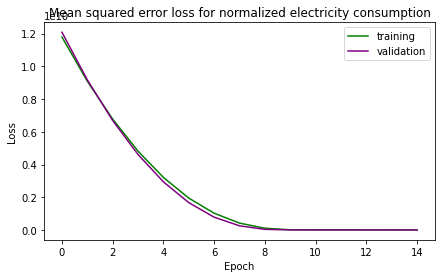

In [ ]:
plot_loss_history(history_ne)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: smac attempted to use a functionality that requires module emcee, but it couldn't be loaded. Please install emcee and retry.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
[WARNING] [2021-04-18 19:06:53,813:tensorflow] AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x7f2544f00a70> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: smac attempted to use a functionality that requires module emcee, but it couldn't be loaded. Please install emcee and retry.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. Wh

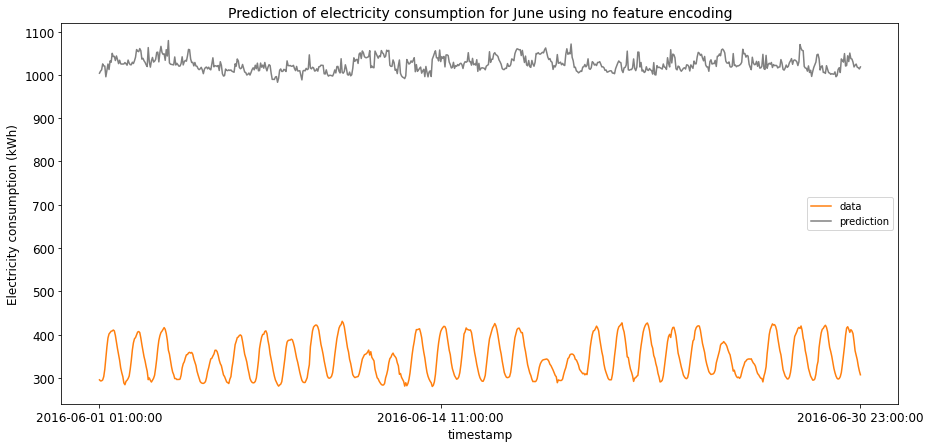

In [ ]:
y = linear_regression_model_ne.predict(X_test)
y_norm= pd.DataFrame(y, columns = ['prediction'])
y_norm['timestamp'] = np.array(timestamp_test)
test_features_new['meter_reading']  = y_test
test_features_new['timestamp']  = np.array(timestamp_test)  

figure(figsize =(15,7))
plt.plot(test_features_new.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]), color = 'C1', label = 'data')
plt.plot(y_norm.groupby(by = "timestamp").mean().filter(["timestamp", "prediction"]), color = 'gray', label = 'prediction')
plt.xlabel('timestamp', fontsize = 12)
plt.ylabel('Electricity consumption (kWh)', fontsize = 12)
plt.title('Prediction of electricity consumption for June using no feature encoding', fontsize = 14)
len_ts = len(timestamp_test.values)
plt.xticks([timestamp_test.values[0],timestamp_test.values[int(len_ts/2)],timestamp_test.values[-1]], fontsize = '12')
plt.yticks(fontsize = 12)
plt.legend()
plt.show()

#### Calculate the metric:

In [ ]:
test_features_ne = X_test
test_labels_ne = y_test
y_pred_ne = linear_regression_model_ne.predict(test_features_ne)
y_norm_ne= pd.DataFrame(y_pred_ne, columns = ['prediction'])
y_norm_ne['timestamp'] = np.array(timestamp_test)
test_features_new = pd.DataFrame(test_labels_ne, columns = ['meter_reading'])
test_features_new['timestamp']  = np.array(timestamp_test) 

y_test_all = test_features_new.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]).meter_reading.values
y_hat_all = y_norm_ne.groupby(by = "timestamp").mean().filter(["timestamp", "prediction"]).prediction.values
std = np.std(y_test_all)
calculate_rmse_metric(y_test_all,y_hat_all)/std

15.924083004905864